# The Independent distribution

> In this post, we will learn the Independent distribution model. This is the summary of lecture "Probabilistic Deep Learning with Tensorflow 2" from Coursera.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Deep_Learning, Tensorflow, Probability]
- image: 

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (16, 10)

print("Tensorflow : v" + tf.__version__)
print("Tensorflow probability : v" + tfp.__version__)

Tensorflow : v2.3.1
Tensorflow probability : v0.11.1


## Example - Rank is 1

In [2]:
tfd = tfp.distributions

mv_normal = tfd.MultivariateNormalDiag(loc=[-1., 0.5], scale_diag=[1., 1.5])
print(mv_normal)

tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[], event_shape=[2], dtype=float32)


In [3]:
batched_normal = tfd.Normal(loc=[-1., 0.5], scale=[1., 1.5])
print(batched_normal)

tfp.distributions.Normal("Normal", batch_shape=[2], event_shape=[], dtype=float32)


In [4]:
mv_normal.log_prob([-.2, 1.8])

<tf.Tensor: shape=(), dtype=float32, numpy=-2.9388978>

In [5]:
batched_normal.log_prob([-0.2, 1.8])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.2389386, -1.699959 ], dtype=float32)>

In [6]:
independent_normal = tfd.Independent(batched_normal, reinterpreted_batch_ndims=1)
print(independent_normal)

tfp.distributions.Independent("IndependentNormal", batch_shape=[], event_shape=[2], dtype=float32)


In [7]:
independent_normal.log_prob([-0.2, 1.8])

<tf.Tensor: shape=(), dtype=float32, numpy=-2.9388976>

## Example - rank that is higher than 1

In [8]:
batched_normal = tfd.Normal(
    loc=[[-1, 0.5], [0., 1.], [0.3, -0.1]],
    scale=[[1., 1.5], [0.2, 0.8], [2., 1.]]
)
print(batched_normal)

tfp.distributions.Normal("Normal", batch_shape=[3, 2], event_shape=[], dtype=float32)


In [9]:
independent_normal = tfd.Independent(batched_normal, reinterpreted_batch_ndims=1)
print(independent_normal)

tfp.distributions.Independent("IndependentNormal", batch_shape=[3], event_shape=[2], dtype=float32)


In [10]:
independent_normal = tfd.Independent(batched_normal, reinterpreted_batch_ndims=2)
print(independent_normal)

tfp.distributions.Independent("IndependentNormal", batch_shape=[], event_shape=[3, 2], dtype=float32)


## Coding Tutorials

In [11]:
# Start by defining a batch of two univariate Gaussians, then
# Combine them into a bivariate Gaussian with independent components
locs = [-1., 1]
scales = [0.5, 1.]
batch_of_normals = tfd.Normal(loc=locs, scale=scales)

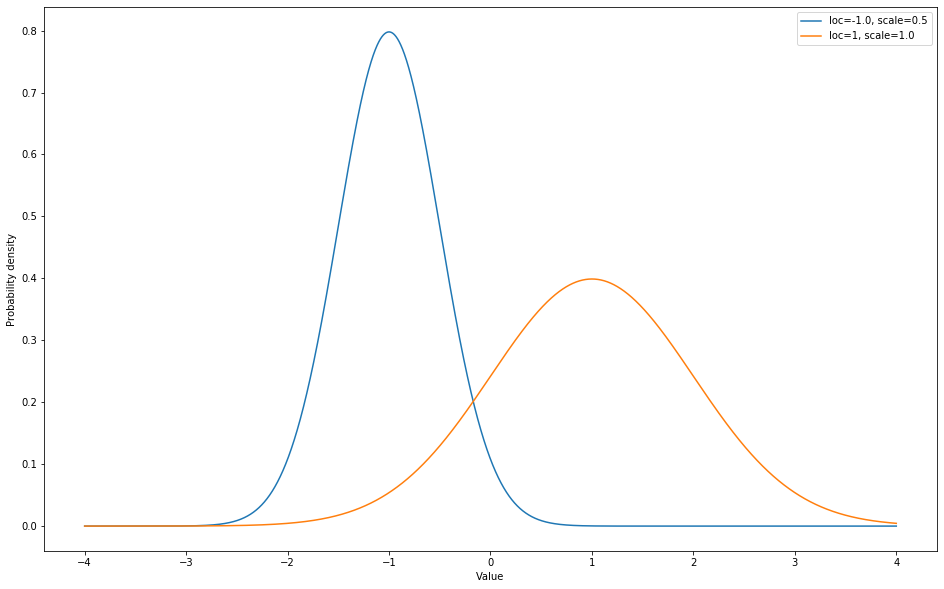

In [12]:
# Univariate density functions
import seaborn as sns

t = np.linspace(-4, 4, 10000)
densities = batch_of_normals.prob(np.repeat(t[:, tf.newaxis], 2, axis=1))

sns.lineplot(t, densities[:, 0], label='loc={}, scale={}'.format(locs[0], scales[0]))
sns.lineplot(t, densities[:, 1], label='loc={}, scale={}'.format(locs[1], scales[1]))
plt.ylabel('Probability density')
plt.xlabel('Value')
plt.legend()
plt.show()

In [13]:
# Check their batch_shape and event_shape
batch_of_normals

<tfp.distributions.Normal 'Normal' batch_shape=[2] event_shape=[] dtype=float32>

In [14]:
# Use Independent to convert the batch shape to the event shape
bivariate_normal_from_Independent = tfd.Independent(batch_of_normals,
                                                    reinterpreted_batch_ndims=1)

In [15]:
# Note that dimension from batch_shape has shifted to event_shape
bivariate_normal_from_Independent

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[2] dtype=float32>

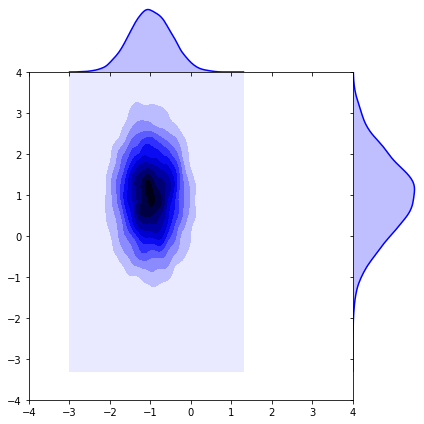

In [16]:
# Create a plot showing joint density contours and marginal density functions
samples = bivariate_normal_from_Independent.sample(10000)
x1 = samples[:, 0]
x2 = samples[:, 1]
sns.jointplot(x1, x2, kind='kde', space=0, color='b', xlim=[-4, 4], ylim=[-4, 4])
plt.show()

In [17]:
# Use MultivariateNormalDiag to create the equivalent distribution
# Note that diagonal covariance matrix => no correlation => independence 
# (for the multivariate normal distribution)
bivariate_normal_from_Multivariate = tfd.MultivariateNormalDiag(loc=locs, scale_diag=scales)
bivariate_normal_from_Multivariate

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

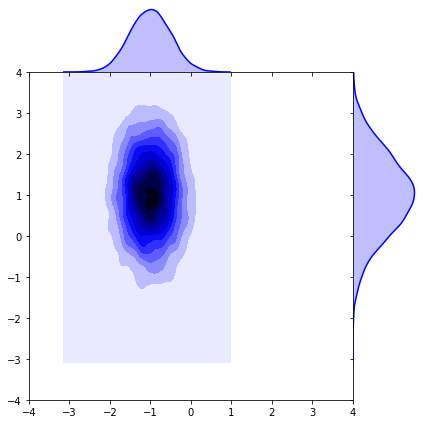

In [18]:
# Plot the joint density function of bivariate_normal_from_Independent
# Refer back to bivariate_normal_from_Independent to show that the plot is the same
# Summarize how Independent has been used
samples = bivariate_normal_from_Multivariate.sample(10000)
x1 = samples[:, 0]
x2 = samples[:, 1]
sns.jointplot(x1, x2, kind='kde', space=0, color='b', xlim=[-4, 4], ylim=[-4, 4])
plt.show()

### Shifting batch dimensions to event dimensions using `reinterpreted_batch_ndims`

In [19]:
# Deomnstrate use of reinterpreted_batch_ndims
# By default all batch dims except the first are transferred to event dims

loc_grid =[[-100., -100.],
           [100., 100.],
           [0., 0.]]

scale_grid = [[1., 10.],
              [1., 10.],
              [1., 1.]]

normals_batch_3by2_event_1 = tfd.Normal(loc=loc_grid, scale=scale_grid)

In [20]:
# highlight batch_shape
normals_batch_3by2_event_1

<tfp.distributions.Normal 'Normal' batch_shape=[3, 2] event_shape=[] dtype=float32>

In [21]:
# We now have a batch of 3 bivariate normal distributions,
# each parameterised by a column of our original parameter grid

normals_batch_3_event_2 = tfd.Independent(normals_batch_3by2_event_1)
normals_batch_3_event_2

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[3] event_shape=[2] dtype=float32>

In [22]:
# Evaluate log_prob
normals_batch_3_event_2.log_prob(value=[[-10., 10.],
                                        [100., 100.],
                                        [1., 1.]])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-4.1146406e+03, -4.1404624e+00, -2.8378770e+00], dtype=float32)>

In [24]:
# Can reinterprete _all_ batch dimensions as event dimensions
normals_batch_1_event_3by2 = tfd.Independent(normals_batch_3by2_event_1, 
                                            reinterpreted_batch_ndims=2)
normals_batch_1_event_3by2

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[3, 2] dtype=float32>

In [25]:
# Take log_probs
normals_batch_1_event_3by2.log_prob(value=[[-10., 10.],
                                           [100., 100.], 
                                           [1., 1.]])

<tf.Tensor: shape=(), dtype=float32, numpy=-4121.619>

### Using `Independent` to build a Naive Bayes classifier

#### Introduction to `newsgroups` dataset

In this section, just load the dataset, fetch train/test splits, probably choose a subset of the data.
Construct the class conditional feature distribution (with Independent, using the Naive Bayes assumption) and sample from it. We can just use the ML estimates for parameters, in later tutorial we will learn them.

In [26]:
# Convenience function for retrieving the 20 newsgroups data set

# Usenet was a forerunner to modern internet forums
# Users could post and read articles
# Newsgroup corresponded to a topic
# Example topics in this data set: IBM computer hardware, baseball
# Our objective is to use an article's contents to predict its newsgroup,
# a 20-class classification problem.

# 18000 newsgroups, posts on 20 topics
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
# Get the train data
newsgroups_data = fetch_20newsgroups(data_home='20_Newsgroup_Data/', subset='train')

In [28]:
print(newsgroups_data['DESCR'])

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality 

In [29]:
# Example article
print(newsgroups_data['data'][0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [30]:
# Associated label
newsgroups_data['target'][0]

7

In [31]:
# Name of label
newsgroups_data['target_names'][7]

'rec.autos'

In [33]:
# Preprocessing boilerplate
n_documents = len(newsgroups_data['data'])
count_vectorizer = CountVectorizer(input='content', binary=True, max_df=0.25,
                                   min_df=1.01/n_documents)
binary_bag_of_words = count_vectorizer.fit_transform(newsgroups_data['data'])

In [34]:
# Check shape
binary_bag_of_words.shape

(11314, 56365)

In [35]:
# Check that the fit has been successful
count_vectorizer.inverse_transform(binary_bag_of_words[0, :])

[array(['lerxst', 'wam', 'umd', 'where', 'thing', 'car', 'rac3',
        'maryland', 'college', 'park', '15', 'wondering', 'anyone',
        'could', 'enlighten', 'saw', 'day', 'door', 'sports', 'looked',
        'late', '60s', 'early', '70s', 'called', 'bricklin', 'doors',
        'were', 'really', 'small', 'addition', 'front', 'bumper',
        'separate', 'rest', 'body', 'tellme', 'model', 'name', 'engine',
        'specs', 'years', 'production', 'made', 'history', 'whatever',
        'info', 'funky', 'looking', 'please', 'mail', 'thanks', 'il',
        'brought', 'neighborhood'], dtype='<U80')]

In [36]:
inv_vocabulary = {value:key for key, value in count_vectorizer.vocabulary_.items()}

#### A Naive Bayes classifier for `newsgroup`

Each feature vector $x$ is a list of indicators for whether a word appears in the article. $x_i$ is 1 if the $i$th word appears, and 0 otherwise. `inv_vocabulary` matches word indices $i$ to words.

Each label $y$ is a value in $0, 1, \ldots, 19$.

The parts of a naive Bayes classifier for this problem can be summarised as:  


- A probability distribution for the feature vector by class, $p(x|y = j)$ for each $j = 0, 1, \ldots, 19$. These probability distributions are assumed to have independent components: we can factorize the joint probability as a product of marginal probabilities
\begin{equation}
    p(x|y = j) = \prod_{i=1}^d p(x_i|y = j)
\end{equation}
These marginal probability distributions are Bernoulli distributions, each of which has a single parameter $\theta_{ji} := p(x_i = 1|y = j)$. This parameter is the probability of observing word $i$ in an article of class $j$. 

- We will use the Laplace smoothed maximum likelihood estimate to compute these parameters. Laplace smoothing involves adding small counts to every feature for each class. Else, if a feature did not appear in the training set of a class, but then we observed it in our test data the log probability would be undefined.

- A collection of class prior probabilities $p(y = j)$. These will be set by computing the class base rates in the training set.  


- A function for computing the probability of class membership via Bayes' theorem:  

\begin{equation}
    p(y = j|x) = \frac{p(x|y = j)p(y = j)}{p(x)}
\end{equation}

In [37]:
# Compute the parameter estimates (adjusted fraction of documents in class that contain word)

n_classes = newsgroups_data['target'].max() + 1
y = newsgroups_data['target']
n_words = binary_bag_of_words.shape[1]

alpha = 1e-6 # parameters for Laplace smoothing

theta = np.zeros([n_classes, n_words]) # stores parameter values - prob. word given class
for c_k in range(n_classes): # 0, 1, ..., 19
    class_mask = (y == c_k)
    N = class_mask.sum() # number of articles in class
    theta[c_k, :] = (binary_bag_of_words[class_mask, :].sum(axis=0) + alpha)/(N + alpha*2)

In [38]:
# Check whether the most probable word in each class is reasonable

most_probable_word_ix = theta.argmax(axis=1) # most probable word for each class

for j, ix in enumerate(most_probable_word_ix):
    print('Most probable word in class {} is "{}".'.format(newsgroups_data['target_names'][j],
                                                           inv_vocabulary[ix]))

Most probable word in class alt.atheism is "people".
Most probable word in class comp.graphics is "graphics".
Most probable word in class comp.os.ms-windows.misc is "windows".
Most probable word in class comp.sys.ibm.pc.hardware is "thanks".
Most probable word in class comp.sys.mac.hardware is "mac".
Most probable word in class comp.windows.x is "window".
Most probable word in class misc.forsale is "sale".
Most probable word in class rec.autos is "car".
Most probable word in class rec.motorcycles is "dod".
Most probable word in class rec.sport.baseball is "he".
Most probable word in class rec.sport.hockey is "ca".
Most probable word in class sci.crypt is "clipper".
Most probable word in class sci.electronics is "use".
Most probable word in class sci.med is "reply".
Most probable word in class sci.space is "space".
Most probable word in class soc.religion.christian is "god".
Most probable word in class talk.politics.guns is "people".
Most probable word in class talk.politics.mideast is 

In [39]:
# Define a distribution for each class
batch_of_bernoullis = tfd.Bernoulli(probs=theta)
p_x_given_y = tfd.Independent(batch_of_bernoullis, 
                             reinterpreted_batch_ndims=1)
p_x_given_y

<tfp.distributions.Independent 'IndependentBernoulli' batch_shape=[20] event_shape=[56365] dtype=int32>

In [40]:
# Take a sample of words from each class
n_samples = 10
sample = p_x_given_y.sample(n_samples)
sample.shape

TensorShape([10, 20, 56365])

In [41]:
# Choose a class
chosen_class = 15
newsgroups_data['target_names'][chosen_class]

'soc.religion.christian'

In [42]:
# Indicators for words that appear in the sample
class_sample = sample[:, chosen_class, :]
class_sample

<tf.Tensor: shape=(10, 56365), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>

In [43]:
# Perform inverse transorm to test quality of fit
count_vectorizer.inverse_transform(class_sample)

[array(['05', '15', '18', '19', '20', '219', '60', '_just_', 'administer',
        'affirm', 'also', 'another', 'anytime', 'apostles', 'argument',
        'atheist', 'athena', 'avoid', 'away', 'battle', 'before',
        'behaviour', 'beholder', 'bhagavad', 'bit', 'boast', 'both',
        'bowermaster', 'church', 'circumstances', 'claim', 'cleveland',
        'color', 'csd', 'day', 'deny', 'described', 'doubt', 'during',
        'est', 'ever', 'fact', 'faith', 'fall', 'falty', 'far', 'focus',
        'further', 'gives', 'giving', 'going', 'good', 'graduate', 'great',
        'haya', 'hindu', 'his', 'horsley', 'however', 'humanity', 'hurt',
        'impending', 'interpretation', 'judaism', 'justified', 'kant',
        'learn', 'limits', 'little', 'liturgy', 'lock', 'look', 'makes',
        'married', 'may', 'maybe', 'mean', 'michael', 'might', 'mike',
        'never', 'night', 'notes', 'obviously', 'offshoots', 'old',
        'opinions', 'order', 'others', 'our', 'own', 'part', 'passage